# JSON Parsor
---

## 1. environment setting
---

### 1. import package

In [4]:
import json
import os
import glob
import folium
import csv
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from shapely import wkt
from shapely import affinity
from tqdm.notebook import tqdm

### 2. set path

In [5]:
BASE_PATH = os.path.join(os.getenv('HOME'), 'workspace/Hackerton') # project folder
DATA_PATH = os.path.join(BASE_PATH, 'RSI_OP_NIA_AIHUB') # data folder
SAMPLE_GEOJSON_PATH = os.path.join(DATA_PATH, 'buildings/training/label/BLD00001_PS3_K3A_NIA0276.json') # sample geojson file path
MERGED_PATH = os.path.join(DATA_PATH, 'merged') # summary dir folder

BUILDINGS_TRAIN_LABEL_PATH = os.path.join(DATA_PATH, 'buildings/training/label')
BUILDINGS_VAL_LABEL_PATH = os.path.join(DATA_PATH, 'buildings/validation/label')
ROADS_TRAIN_LABEL_PATH = os.path.join(DATA_PATH, 'roads/training/label')
ROADS_VAL_LABEL_PATH = os.path.join(DATA_PATH, 'roads/validation/label')

In [6]:
SAMPLE_GEOJSON_PATH

'/home/aiffel-dj15/workspace/Hackerton/RSI_OP_NIA_AIHUB/buildings/training/label/BLD00001_PS3_K3A_NIA0276.json'

### 3. load json file

In [7]:
with open(SAMPLE_GEOJSON_PATH, "r") as st_json:
    st_python = json.load(st_json)

type(st_python)

dict

## 2. Parse Json to class
---

### 1. define class :: type1

![CD_geojson.png](./assets/CD_geojson.png)

In [8]:
class Property():
    def __init__(self, raw):
        self.object_imcoords = raw['object_imcoords'] if 'object_imcoords' in raw else "EMPTY"
        self.building_imcoords = raw['building_imcoords'] if 'building_imcoords' in raw else "EMPTY"
        self.road_imcoords = raw['road_imcoords'] if 'road_imcoords' in raw else "EMPTY"
        self.image_id = raw['image_id'] if 'image_id' in raw else None
        self.ingest_time = raw['ingest_time'] if 'ingest_time' in raw else None
        self.type_id = raw['type_id'] if 'type_id' in raw else None
        self.type_name = raw['type_name'] if 'type_name' in raw else None
        
    def is_building(self):
        ans = False
        if self.building_imcoords != "EMPTY" and self.road_imcoords == "EMPTY":
            ans = True
        return ans
    
    def is_road(self):
        ans = False
        if self.building_imcoords == "EMPTY" and self.road_imcoords != "EMPTY":
            ans = True
        return ans
    
    def __str__(self):
        return f'''{{
    object_imcoords : {self.object_imcoords},
    building_imcoords : {self.building_imcoords},
    road_imcoords : {self.road_imcoords},
    image_id : {self.image_id},
    ingest_time : {self.ingest_time},
    type_id : {self.type_id},
    type_name : {self.type_name}
}}
        '''
    
    def __repr__(self):
        data_type = "building" if self.is_building() else "road"
        _str = ""
        if data_type == "building":
            _str = f'Property : data type({data_type}), coordinates({self.building_imcoords})'
        else:
            _str = f'Property : data type({data_type}), coordinates({self.road_imcoords})'
        return _str

In [9]:
class Geometry():
    def __init__(self, raw):
        self.coordinates = raw['coordinates'] if 'coordinates' in raw else []
        self.type = raw['type'] if 'type' in raw else ""

    def __str__(self):
        return f'''{{
    type : {self.type},
    coordinates : {self.coordinates}
}}
        '''
    
    def __repr__(self):
        return f'Geometry : data type({self.type}), coordinates({self.coordinates})'

In [10]:
class Feature():
    def __init__(self, raw):
        self.type = "Feature"
        self.geometry = Geometry(raw['geometry']) if 'geometry' in raw else None
        self.properties = Property(raw['properties']) if 'properties' in raw else None

    def __str__(self):
        return 'Feature : Geometry({}), data type({})'.format(
            self.geometry.type,
            "building" if self.properties.is_building() else "road"
        )
    
    def __repr__(self):
        return self.__str__()

In [11]:
class FeatureCollection():
    def __init__(self, raw):
        self.type = "FeatureCollection"
        self.features = []
        
        if 'features' in raw and type(raw['features']) == list:
            self.features = [ Feature(feature) for feature in raw['features'] ]
    
    def __str__(self):
        return f'FeatureCollection with {len(self.features)} features'
    
    def __repr__(self):
        return self.__str__()

In [12]:
fc = FeatureCollection(st_python)

In [13]:
fc

FeatureCollection with 215 features

In [14]:
fc.features[0]

Feature : Geometry(Polygon), data type(building)

In [15]:
fc.features[0].geometry

Geometry : data type(Polygon), coordinates([[31.4347031225, 30.0413951468, 0.0], [31.4405428056, 30.0414645232, 0.0], [31.4404632046, 30.0465452603, 0.0], [31.4346232236, 30.0464758698, 0.0]])

In [16]:
fc.features[0].properties

Property : data type(building), coordinates(856.2952642894032,1000.8046984782792,828.0083112141339,1024,879.9702141458786,1023.8647145722488,878.740346620867,1015.2556418971668)

In [17]:
print(fc.features[0].properties)

{
    object_imcoords : EMPTY,
    building_imcoords : 856.2952642894032,1000.8046984782792,828.0083112141339,1024,879.9702141458786,1023.8647145722488,878.740346620867,1015.2556418971668,
    road_imcoords : EMPTY,
    image_id : BLD00001_PS3_K3A_NIA0276.png,
    ingest_time : 2020-10-27T02:04:23.355595Z,
    type_id : 2,
    type_name : 아파트
}
        


In [18]:
img = [feature.properties.image_id for feature in fc.features]
set(img)

{'BLD00001_PS3_K3A_NIA0276.png'}

### 2. define class :: type 2

![image](./assets/CD_object.png)

In [19]:
class Object():
    def __init__(self, raw):
        self.area_id = raw['image_id'] if 'image_id' in raw else None
        self.imcoords = raw['imcoords_pix'] if 'imcoords_pix' in raw else None
        self.image_id = raw['imcoords_geo'] if 'imcoords_geo' in raw else None
        self.type = raw['type'] if 'type' in raw else None

In [20]:
class Site():
    def __init__(self, coodinates, area_id):
        self.coodinates = coodinates
        self.image_id = image_id
    
    def __str__(self):
        return f'Site({self.image_id}) : {self.coordinates}'

### 3. parsing

#### A. load all json file

In [21]:
def load_json(file_paths):
    res = {}
    for file_path in tqdm(file_paths):
        with open(file_path, "r") as f:
            name = os.path.basename(f.name)
            if name in res:
                print(f'WARNING : file name {naem} is duplicated')
            else:
                res[name] = json.load(f)
    return res

In [22]:
buildings_train_label_pattern = BUILDINGS_TRAIN_LABEL_PATH + r"/*.json"
buildings_val_label_pattern = BUILDINGS_VAL_LABEL_PATH + r"/*.json"
roads_train_label_pattern = ROADS_TRAIN_LABEL_PATH + r"/*.json"
roads_val_label_pattern = ROADS_VAL_LABEL_PATH + r"/*.json"

In [23]:
buildings_train_label_paths = glob.glob(buildings_train_label_pattern)
buildings_val_label_paths = glob.glob(buildings_val_label_pattern)
roads_train_label_paths = glob.glob(roads_train_label_pattern)
roads_val_label_paths = glob.glob(roads_val_label_pattern)

print(f'len(buildings_train_label_paths) : {len(buildings_train_label_paths)}')
print(f'len(buildings_val_label_paths) : {len(buildings_val_label_paths)}')
print(f'len(roads_train_label_paths) : {len(roads_train_label_paths)}')
print(f'len(roads_val_label_paths) : {len(roads_val_label_paths)}')

len(buildings_train_label_paths) : 1238
len(buildings_val_label_paths) : 159
len(roads_train_label_paths) : 1144
len(roads_val_label_paths) : 127


In [24]:
buildings_train_label_json = load_json(buildings_train_label_paths)
buildings_val_label_json = load_json(buildings_val_label_paths)
roads_train_label_json = load_json(roads_train_label_paths)
roads_val_label_json = load_json(roads_val_label_paths)

  0%|          | 0/1238 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/1144 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [25]:
print(f'len(buildings_train_label_json) : {len(buildings_train_label_json)}')
print(f'len(buildings_val_label_json) : {len(buildings_val_label_json)}')
print(f'len(roads_train_label_json) : {len(roads_train_label_json)}')
print(f'len(roads_val_label_json) : {len(roads_val_label_json)}')

len(buildings_train_label_json) : 1238
len(buildings_val_label_json) : 159
len(roads_train_label_json) : 1144
len(roads_val_label_json) : 127


In [26]:
all_keys = list(buildings_train_label_json.keys()) + \
           list(buildings_val_label_json.keys()) + \
           list(roads_train_label_json.keys()) + \
           list(roads_val_label_json.keys())
print(len(all_keys), len(list(set(all_keys))))
### key들에 중복이 존재

2668 2208


#### B. parse json as class

In [27]:
all_json = list(buildings_train_label_json.values()) + \
           list(buildings_val_label_json.values()) +  \
           list(roads_train_label_json.values()) + \
           list(roads_val_label_json.values())
feature_collections = [ FeatureCollection(_json) for _json in tqdm(all_json) ]

  0%|          | 0/2668 [00:00<?, ?it/s]

In [28]:
feature_collections[0]

FeatureCollection with 19 features

In [29]:
feature_collections[0].features[0]

Feature : Geometry(Polygon), data type(building)

In [30]:
feature_collections[0].features[0].geometry

Geometry : data type(Polygon), coordinates([[121.645521032, 31.3252013415, 0.0], [121.6514390441, 31.3252636545, 0.0], [121.6513666044, 31.3303438634, 0.0], [121.6454482746, 31.330281538, 0.0]])

In [31]:
print(feature_collections[0].features[0].properties)

{
    object_imcoords : EMPTY,
    building_imcoords : 370.0623896409653,794.3684520306062,493.91877575044145,874.2271924661566,512.9040612124779,844.6945261918776,499.9458505002943,836.5579752795762,507.1783402001177,823.9011183048852,490.6038846380223,815.4632136550912,490.905238375515,810.6415538552089,481.86462625073574,806.4226015303119,481.2619187757504,808.2307239552678,452.0306062389641,786.2319011183049,458.9617422012949,770.8628605061801,399.8964096527369,731.0841671571512,392.3625662154208,731.9882283696292,383.6233078281342,740.4261330194232,381.8151854031784,746.7545615067687,373.9799882283696,762.1236021188935,379.4043555032372,772.670982931136,375.1854031783402,782.9170100058858,
    road_imcoords : EMPTY,
    image_id : BLD01145_PS3_K3A_NIA0373.png,
    ingest_time : 2020-11-19T00:57:46.430325Z,
    type_id : 3,
    type_name : 공장
}
        


## 3. Abstract Area
---

- wkt
    - 정의 : https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry
    - 데이터 확인 : https://clydedacruz.github.io/openstreetmap-wkt-playground/

### 1. Geometry 추출

In [32]:
geometreis = [ [f.properties.image_id.split('.')[0], f.geometry] for fc in feature_collections for f in fc.features ]
len(geometreis), geometreis[0][0], geometreis[0][1].coordinates

(197978,
 'BLD01145_PS3_K3A_NIA0373',
 [[121.645521032, 31.3252013415, 0.0],
  [121.6514390441, 31.3252636545, 0.0],
  [121.6513666044, 31.3303438634, 0.0],
  [121.6454482746, 31.330281538, 0.0]])

### 2. list 형태로 되어 있는 좌표정보(coordinates)를 wkt로 변화

In [33]:
def coor_to_polygon(coordinates):
    """
    [[x1, y1, z1],
     [x2, y2, z2],
     [x3, y3, z3],
     [x4, y4, z4]]
    to
    POLYGON ((x1 y1, x2 y2, x3 y3, x4 y4, x1 y1))
    """
    coordinates.append(coordinates[0])
    wkt = "POLYGON(("
    wkt += ", ".join([" ".join(map(str, coor[:-1])) for coor in coordinates])
    wkt += "))"
    return wkt

In [34]:
areas = [(image_id, coor_to_polygon(geometry.coordinates)) for image_id, geometry in tqdm(geometreis)]
areas = list(set(areas))
print(len(areas), areas[0])

  0%|          | 0/197978 [00:00<?, ?it/s]

2208 ('BLD01607_PS3_K3A_NIA0373', 'POLYGON((121.5405653655 31.2224329094, 121.5464766991 31.2224998636, 121.5463989369 31.2275799254, 121.5404872873 31.2275129578, 121.5405653655 31.2224329094))')


### 3. csv 저장

In [35]:
def save_csv(path, data, fields):
    if type(data) != list:
        assert f'[save_csv] The type of input parameter data must be list.'
    if not data:
        assert f'[save_csv] The parameter data should not empty.'
    if len(data[0]) != len(fields):
        assert f'[save_csv] The number of data column and fields must be same.'
            
    with open(path, "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(fields)
        writer.writerows(data)

In [37]:
MERGED_PATH = os.path.join(DATA_PATH, 'merged')
if not os.path.exists(MERGED_PATH):
    os.makedirs(MERGED_PATH)
save_csv(os.path.join(MERGED_PATH, 'Site.csv'), areas, ['image_id', 'coordinates'])

### 4. 저장된 파일 확인

In [38]:
area_path = os.path.join(MERGED_PATH, 'Site.csv')
df = pd.read_csv(area_path, encoding='utf-8')
df.head(5)

image_id                                        coordinates
0  BLD01607_PS3_K3A_NIA0373  POLYGON((121.5405653655 31.2224329094, 121.546...
1  BLD00236_PS3_K3A_NIA0276  POLYGON((31.3364495275 29.9792100875, 31.34228...
2  BLD00732_PS3_K3A_NIA0277  POLYGON((31.3205464981 30.1093729777, 31.32638...
3  BLD03582_PS3_K3A_NIA0376  POLYGON((10.7529827452 52.4536233652, 10.76126...
4  BLD01562_PS3_K3A_NIA0373  POLYGON((121.6054418823 31.2333148498, 121.611...

In [39]:
df['coordinates'][0]

'POLYGON((121.5405653655 31.2224329094, 121.5464766991 31.2224998636, 121.5463989369 31.2275799254, 121.5404872873 31.2275129578, 121.5405653655 31.2224329094))'

In [40]:
df.describe(include='all')

image_id  \
count                       2208   
unique                      2208   
top     BLD01237_PS3_K3A_NIA0373   
freq                           1   

                                              coordinates  
count                                                2208  
unique                                               2208  
top     POLYGON((-118.2264626883 34.120841683, -118.22...  
freq                                                    1

In [41]:
df['coordinates'] = gpd.GeoSeries.from_wkt(df['coordinates'])
gdf = gpd.GeoDataFrame(df, geometry='coordinates')
gdf.head(5)

image_id                                        coordinates
0  BLD01607_PS3_K3A_NIA0373  POLYGON ((121.54057 31.22243, 121.54648 31.222...
1  BLD00236_PS3_K3A_NIA0276  POLYGON ((31.33645 29.97921, 31.34229 29.97928...
2  BLD00732_PS3_K3A_NIA0277  POLYGON ((31.32055 30.10937, 31.32639 30.10945...
3  BLD03582_PS3_K3A_NIA0376  POLYGON ((10.75298 52.45362, 10.76127 52.45350...
4  BLD01562_PS3_K3A_NIA0373  POLYGON ((121.60544 31.23331, 121.61135 31.233...

In [42]:
list(df['coordinates'][0].exterior.coords)

[(121.5405653655, 31.2224329094),
 (121.5464766991, 31.2224998636),
 (121.5463989369, 31.2275799254),
 (121.5404872873, 31.2275129578),
 (121.5405653655, 31.2224329094)]

In [43]:
type(gdf['coordinates'][0])

shapely.geometry.polygon.Polygon

#### A. **AREA 분포 확인**

In [44]:



m = folium.Map(zoom_start=8, tiles='CartoDB positron')

for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r['coordinates']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['image_id']).add_to(geo_j)
    geo_j.add_to(m)
m

## 4. Abstract Building Object
---

### 1. Buildings 추출

In [45]:
def imcoords_to_wkt(coordinates):
    if coordinates == "":
        return None # Nan
    
    coor = coordinates.split(',')
    if len(coor) < 6:
        return None # 다각형은 세개 이상의 점으로 이루어 진다.
    
    
    coor = [f'{round(float(coor[i]))} {round(float(coor[i+1]))}' for i in range(0, len(coor), 2)]
    coor += [coor[0]]
    wkt = 'POLYGON((' + ", ".join(coor) + '))'
    return wkt

In [46]:
def get_building_attributes(feature):
    return {
        'image_id': feature.properties.image_id.split('.')[0],
        'type': "building",
        'coordinates_pix': imcoords_to_wkt(feature.properties.building_imcoords),
        'coordinates_geo': ""
    }

In [47]:
buildings = [get_building_attributes(f) for fc in feature_collections 
             for f in fc.features 
             if f.properties.is_building()]
buildings = [b for b in buildings if b['coordinates_pix']]
print(len(buildings))

172202


### 2. add site
- coordinates_geo 계산을 위하여 site의 좌표 정보를 불러온다.

In [48]:
site_df = pd.read_csv(area_path, encoding='utf-8')
site_df.head(5)

image_id                                        coordinates
0  BLD01607_PS3_K3A_NIA0373  POLYGON((121.5405653655 31.2224329094, 121.546...
1  BLD00236_PS3_K3A_NIA0276  POLYGON((31.3364495275 29.9792100875, 31.34228...
2  BLD00732_PS3_K3A_NIA0277  POLYGON((31.3205464981 30.1093729777, 31.32638...
3  BLD03582_PS3_K3A_NIA0376  POLYGON((10.7529827452 52.4536233652, 10.76126...
4  BLD01562_PS3_K3A_NIA0373  POLYGON((121.6054418823 31.2333148498, 121.611...

In [49]:
building_df = pd.DataFrame(buildings)
building_df.head(5)

image_id      type  \
0  BLD01145_PS3_K3A_NIA0373  building   
1  BLD01145_PS3_K3A_NIA0373  building   
2  BLD01145_PS3_K3A_NIA0373  building   
3  BLD01145_PS3_K3A_NIA0373  building   
4  BLD01145_PS3_K3A_NIA0373  building   

                                     coordinates_pix coordinates_geo  
0  POLYGON((370 794, 494 874, 513 845, 500 837, 5...                  
1  POLYGON((228 705, 340 780, 350 767, 376 783, 3...                  
2  POLYGON((79 876, 155 923, 254 766, 193 727, 19...                  
3  POLYGON((7 246, 27 216, 26 212, 34 198, 36 200...                  
4  POLYGON((428 397, 381 471, 493 543, 542 467, 4...

In [50]:
merged = pd.merge(building_df, site_df, left_on="image_id", right_on="image_id", how="inner")
merged.head(5)

image_id      type  \
0  BLD01145_PS3_K3A_NIA0373  building   
1  BLD01145_PS3_K3A_NIA0373  building   
2  BLD01145_PS3_K3A_NIA0373  building   
3  BLD01145_PS3_K3A_NIA0373  building   
4  BLD01145_PS3_K3A_NIA0373  building   

                                     coordinates_pix coordinates_geo  \
0  POLYGON((370 794, 494 874, 513 845, 500 837, 5...                   
1  POLYGON((228 705, 340 780, 350 767, 376 783, 3...                   
2  POLYGON((79 876, 155 923, 254 766, 193 727, 19...                   
3  POLYGON((7 246, 27 216, 26 212, 34 198, 36 200...                   
4  POLYGON((428 397, 381 471, 493 543, 542 467, 4...                   

                                         coordinates  
0  POLYGON((121.645521032 31.3252013415, 121.6514...  
1  POLYGON((121.645521032 31.3252013415, 121.6514...  
2  POLYGON((121.645521032 31.3252013415, 121.6514...  
3  POLYGON((121.645521032 31.3252013415, 121.6514...  
4  POLYGON((121.645521032 31.3252013415, 121.6514...

In [51]:
len(building_df), len(merged)

(172202, 172202)

In [52]:
merged['coordinates'] = gpd.GeoSeries.from_wkt(merged['coordinates'])
merged['coordinates_pix'] = gpd.GeoSeries.from_wkt(merged['coordinates_pix'])
merged_gdf = gpd.GeoDataFrame(merged, geometry='coordinates_pix')
merged_gdf.head(5)

image_id      type  \
0  BLD01145_PS3_K3A_NIA0373  building   
1  BLD01145_PS3_K3A_NIA0373  building   
2  BLD01145_PS3_K3A_NIA0373  building   
3  BLD01145_PS3_K3A_NIA0373  building   
4  BLD01145_PS3_K3A_NIA0373  building   

                                     coordinates_pix coordinates_geo  \
0  POLYGON ((370.000 794.000, 494.000 874.000, 51...                   
1  POLYGON ((228.000 705.000, 340.000 780.000, 35...                   
2  POLYGON ((79.000 876.000, 155.000 923.000, 254...                   
3  POLYGON ((7.000 246.000, 27.000 216.000, 26.00...                   
4  POLYGON ((428.000 397.000, 381.000 471.000, 49...                   

                                         coordinates  
0  POLYGON ((121.64552 31.32520, 121.65144 31.325...  
1  POLYGON ((121.64552 31.32520, 121.65144 31.325...  
2  POLYGON ((121.64552 31.32520, 121.65144 31.325...  
3  POLYGON ((121.64552 31.32520, 121.65144 31.325...  
4  POLYGON ((121.64552 31.32520, 121.65144 31.325...

### 3. coordinates_geo 계산

In [53]:
def pix_coor_to_real_coor(site_geo, src, pix_size):
    real_URC = (site_geo.bounds[2], site_geo.bounds[3])
    real_LLC = (site_geo.bounds[0], site_geo.bounds[1])

    pix_width = pix_size # 1024*1024 고정
    pix_height = pix_size

    width_scale = abs((real_URC[0] - real_LLC[0]) / pix_width)
    height_scale = abs((real_URC[1] - real_LLC[1]) / pix_height)

    width_trans = real_LLC[0]
    height_trans = real_LLC[1]

    
    mirrored = affinity.affine_transform(src, [1, 0, 0, -1, 0, pix_height ])
    return affinity.affine_transform(mirrored, [width_scale, 0, 0, height_scale, width_trans, height_trans ])

In [54]:
list(merged_gdf.loc[0]['coordinates'].exterior.coords)

[(121.645521032, 31.3252013415),
 (121.6514390441, 31.3252636545),
 (121.6513666044, 31.3303438634),
 (121.6454482746, 31.330281538),
 (121.645521032, 31.3252013415)]

In [55]:
merged_gdf['coordinates_geo'] = merged_gdf.apply(lambda x: pix_coor_to_real_coor(x.coordinates, x.coordinates_pix, 1024), axis='columns')
merged_gdf.head(5)

image_id      type  \
0  BLD01145_PS3_K3A_NIA0373  building   
1  BLD01145_PS3_K3A_NIA0373  building   
2  BLD01145_PS3_K3A_NIA0373  building   
3  BLD01145_PS3_K3A_NIA0373  building   
4  BLD01145_PS3_K3A_NIA0373  building   

                                     coordinates_pix  \
0  POLYGON ((370.000 794.000, 494.000 874.000, 51...   
1  POLYGON ((228.000 705.000, 340.000 780.000, 35...   
2  POLYGON ((79.000 876.000, 155.000 923.000, 254...   
3  POLYGON ((7.000 246.000, 27.000 216.000, 26.00...   
4  POLYGON ((428.000 397.000, 381.000 471.000, 49...   

                                     coordinates_geo  \
0  POLYGON ((121.6476129081107 31.32635640012989,...   
1  POLYGON ((121.6467821568715 31.32680335759971,...   
2  POLYGON ((121.6459104531064 31.32594459661836,...   
3  POLYGON ((121.6454892271259 31.32910845286543,...   
4  POLYGON ((121.6479522290394 31.32835013176494,...   

                                         coordinates  
0  POLYGON ((121.64552 31.32520, 121.65144 31.325...  
1  POLYGON ((121.64552 31.32520, 121.65144 31.325...  
2  POLYGON ((121.64552 31.32520, 121.65144 31.325...  
3  POLYGON ((121.64552 31.32520, 121.65144 31.325...  
4  POLYGON ((121.64552 31.32520, 121.65144 31.325...

#### A. 계산된 데이터 확인 1 - matplot

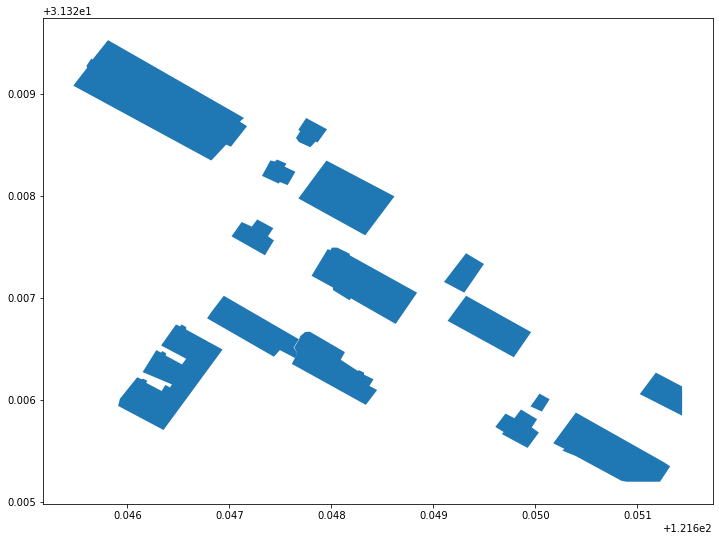

In [56]:
tmp = gpd.GeoSeries(merged_gdf[:15]['coordinates_geo'])
tmp.plot(figsize=(12,12))
plt.show()

#### B. 계산된 데이터 확인 2 - folium

In [57]:
m = folium.Map(zoom_start=17, location=[39.7213631342, -104.8953397997], tiles='CartoDB positron')

for i, r in merged_gdf[:50].iterrows():    
    sim_geo = gpd.GeoSeries(r['coordinates_geo']).simplify(tolerance=0.00001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(f'idx({i})').add_to(geo_j)
    geo_j.add_to(m)
m

### 4. csv 저장

In [58]:
merged_gdf.drop('coordinates', axis=1).to_csv(os.path.join(MERGED_PATH, 'Buildings.csv'),',', index=False)

### 5. 저장된 파일 확인

In [59]:
area_path = os.path.join(MERGED_PATH, 'Buildings.csv')
df = pd.read_csv(area_path, encoding='utf-8')
df.head(5)

image_id      type  \
0  BLD01145_PS3_K3A_NIA0373  building   
1  BLD01145_PS3_K3A_NIA0373  building   
2  BLD01145_PS3_K3A_NIA0373  building   
3  BLD01145_PS3_K3A_NIA0373  building   
4  BLD01145_PS3_K3A_NIA0373  building   

                                     coordinates_pix  \
0  POLYGON ((370 794, 494 874, 513 845, 500 837, ...   
1  POLYGON ((228 705, 340 780, 350 767, 376 783, ...   
2  POLYGON ((79 876, 155 923, 254 766, 193 727, 1...   
3  POLYGON ((7 246, 27 216, 26 212, 34 198, 36 20...   
4  POLYGON ((428 397, 381 471, 493 543, 542 467, ...   

                                     coordinates_geo  
0  POLYGON ((121.6476129081107 31.32635640012989,...  
1  POLYGON ((121.6467821568715 31.32680335759971,...  
2  POLYGON ((121.6459104531064 31.32594459661836,...  
3  POLYGON ((121.6454892271259 31.32910845286543,...  
4  POLYGON ((121.6479522290394 31.32835013176494,...

In [60]:
df['coordinates_pix'] = gpd.GeoSeries.from_wkt(df['coordinates_pix'])
df['coordinates_geo'] = gpd.GeoSeries.from_wkt(df['coordinates_geo'])
gdf = gpd.GeoDataFrame(df, geometry='coordinates_pix')
gdf.tail(5)

image_id      type  \
172197  BLD01548_PS3_K3A_NIA0373  building   
172198  BLD01548_PS3_K3A_NIA0373  building   
172199  BLD01548_PS3_K3A_NIA0373  building   
172200  BLD01548_PS3_K3A_NIA0373  building   
172201  BLD01548_PS3_K3A_NIA0373  building   

                                          coordinates_pix  \
172197  POLYGON ((80.000 0.000, 83.000 6.000, 86.000 1...   
172198  POLYGON ((128.000 299.000, 135.000 293.000, 16...   
172199  POLYGON ((180.000 292.000, 198.000 292.000, 19...   
172200  POLYGON ((171.000 342.000, 172.000 349.000, 17...   
172201  POLYGON ((436.000 611.000, 417.000 617.000, 41...   

                                          coordinates_geo  
172197  POLYGON ((121.52306 31.23754, 121.52308 31.237...  
172198  POLYGON ((121.52334 31.23604, 121.52338 31.236...  
172199  POLYGON ((121.52365 31.23607, 121.52375 31.236...  
172200  POLYGON ((121.52359 31.23582, 121.52360 31.235...  
172201  POLYGON ((121.52515 31.23447, 121.52503 31.234...

## 5. Abstract Road Object
---

### 1. Road 추출

In [61]:
def get_road_attributes(feature):
    return {
        'image_id': feature.properties.image_id.split('.')[0],
        'type': "road",
        'coordinates_pix': imcoords_to_wkt(feature.properties.road_imcoords),
        'coordinates_geo': ""
    }

In [62]:
roads = [get_road_attributes(f) for fc in feature_collections 
             for f in fc.features 
             if f.properties.is_road()]
roads = [r for r in roads if r['coordinates_pix']]
print(len(roads))

25698


### 2. add site

In [63]:
area_path = os.path.join(MERGED_PATH, 'Site.csv')
site_df = pd.read_csv(area_path, encoding='utf-8')
site_df.head(5)

image_id                                        coordinates
0  BLD01607_PS3_K3A_NIA0373  POLYGON((121.5405653655 31.2224329094, 121.546...
1  BLD00236_PS3_K3A_NIA0276  POLYGON((31.3364495275 29.9792100875, 31.34228...
2  BLD00732_PS3_K3A_NIA0277  POLYGON((31.3205464981 30.1093729777, 31.32638...
3  BLD03582_PS3_K3A_NIA0376  POLYGON((10.7529827452 52.4536233652, 10.76126...
4  BLD01562_PS3_K3A_NIA0373  POLYGON((121.6054418823 31.2333148498, 121.611...

In [64]:
road_df = pd.DataFrame(roads)
road_df.head(5)

image_id  type  \
0  BLD01563_PS3_K3A_NIA0373  road   
1  BLD01563_PS3_K3A_NIA0373  road   
2  BLD01563_PS3_K3A_NIA0373  road   
3  BLD01563_PS3_K3A_NIA0373  road   
4  BLD01563_PS3_K3A_NIA0373  road   

                                     coordinates_pix coordinates_geo  
0  POLYGON((0 154, 117 156, 173 156, 198 153, 213...                  
1  POLYGON((964 60, 976 51, 982 38, 986 26, 986 0...                  
2  POLYGON((909 1024, 804 963, 658 894, 521 840, ...                  
3  POLYGON((855 1024, 783 984, 699 943, 608 903, ...                  
4  POLYGON((195 1024, 197 878, 191 845, 181 825, ...

In [65]:
merged = pd.merge(road_df, site_df, left_on="image_id", right_on="image_id", how="inner")
merged.head(5)

image_id  type  \
0  BLD01563_PS3_K3A_NIA0373  road   
1  BLD01563_PS3_K3A_NIA0373  road   
2  BLD01563_PS3_K3A_NIA0373  road   
3  BLD01563_PS3_K3A_NIA0373  road   
4  BLD01563_PS3_K3A_NIA0373  road   

                                     coordinates_pix coordinates_geo  \
0  POLYGON((0 154, 117 156, 173 156, 198 153, 213...                   
1  POLYGON((964 60, 976 51, 982 38, 986 26, 986 0...                   
2  POLYGON((909 1024, 804 963, 658 894, 521 840, ...                   
3  POLYGON((855 1024, 783 984, 699 943, 608 903, ...                   
4  POLYGON((195 1024, 197 878, 191 845, 181 825, ...                   

                                         coordinates  
0  POLYGON((121.6113540603 31.2333788422, 121.617...  
1  POLYGON((121.6113540603 31.2333788422, 121.617...  
2  POLYGON((121.6113540603 31.2333788422, 121.617...  
3  POLYGON((121.6113540603 31.2333788422, 121.617...  
4  POLYGON((121.6113540603 31.2333788422, 121.617...

In [66]:
len(road_df), len(merged)

(25698, 25698)

In [67]:
merged['coordinates'] = gpd.GeoSeries.from_wkt(merged['coordinates'])
merged['coordinates_pix'] = gpd.GeoSeries.from_wkt(merged['coordinates_pix'])
merged_gdf = gpd.GeoDataFrame(merged, geometry='coordinates_pix')
merged_gdf.head(5)

image_id  type  \
0  BLD01563_PS3_K3A_NIA0373  road   
1  BLD01563_PS3_K3A_NIA0373  road   
2  BLD01563_PS3_K3A_NIA0373  road   
3  BLD01563_PS3_K3A_NIA0373  road   
4  BLD01563_PS3_K3A_NIA0373  road   

                                     coordinates_pix coordinates_geo  \
0  POLYGON ((0.000 154.000, 117.000 156.000, 173....                   
1  POLYGON ((964.000 60.000, 976.000 51.000, 982....                   
2  POLYGON ((909.000 1024.000, 804.000 963.000, 6...                   
3  POLYGON ((855.000 1024.000, 783.000 984.000, 6...                   
4  POLYGON ((195.000 1024.000, 197.000 878.000, 1...                   

                                         coordinates  
0  POLYGON ((121.61135 31.23338, 121.61727 31.233...  
1  POLYGON ((121.61135 31.23338, 121.61727 31.233...  
2  POLYGON ((121.61135 31.23338, 121.61727 31.233...  
3  POLYGON ((121.61135 31.23338, 121.61727 31.233...  
4  POLYGON ((121.61135 31.23338, 121.61727 31.233...

### 3. coordinates_geo 계산

In [68]:
merged_gdf['coordinates_geo'] = merged_gdf.apply(lambda x: pix_coor_to_real_coor(x.coordinates, x.coordinates_pix, 1024), axis='columns')
merged_gdf.head(5)

image_id  type  \
0  BLD01563_PS3_K3A_NIA0373  road   
1  BLD01563_PS3_K3A_NIA0373  road   
2  BLD01563_PS3_K3A_NIA0373  road   
3  BLD01563_PS3_K3A_NIA0373  road   
4  BLD01563_PS3_K3A_NIA0373  road   

                                     coordinates_pix  \
0  POLYGON ((0.000 154.000, 117.000 156.000, 173....   
1  POLYGON ((964.000 60.000, 976.000 51.000, 982....   
2  POLYGON ((909.000 1024.000, 804.000 963.000, 6...   
3  POLYGON ((855.000 1024.000, 783.000 984.000, 6...   
4  POLYGON ((195.000 1024.000, 197.000 878.000, 1...   

                                     coordinates_geo  \
0  POLYGON ((121.6112797365 31.23774917309746, 12...   
1  POLYGON ((121.6169154844086 31.23822136976914,...   
2  POLYGON ((121.6165939427748 31.2333788422, 121...   
3  POLYGON ((121.6162782473525 31.2333788422, 121...   
4  POLYGON ((121.6124197477471 31.2333788422, 121...   

                                         coordinates  
0  POLYGON ((121.61135 31.23338, 121.61727 31.233...  
1  POLYGON ((121.61135 31.23338, 121.61727 31.233...  
2  POLYGON ((121.61135 31.23338, 121.61727 31.233...  
3  POLYGON ((121.61135 31.23338, 121.61727 31.233...  
4  POLYGON ((121.61135 31.23338, 121.61727 31.233...

#### A. 계산된 데이터 확인 1 - matplot

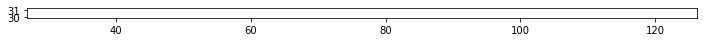

In [69]:
tmp = gpd.GeoSeries(merged_gdf[:15]['coordinates_geo'])
tmp.plot(figsize=(12,12))
plt.show()

#### B. 계산된 데이터 확인 2 - folium

In [70]:
m = folium.Map(zoom_start=17, location=[33.9516227282, -118.2718820291], tiles='cartodb positron')

for i, r in merged_gdf[:50].iterrows():    
    sim_geo = gpd.GeoSeries(r['coordinates_geo']).simplify(tolerance=0.00001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(f'idx({i})').add_to(geo_j)
    geo_j.add_to(m)
m

### 4. csv 저장

In [71]:
merged_gdf.drop('coordinates', axis=1).to_csv(os.path.join(MERGED_PATH, 'Roads.csv'),',', index=False)

### 5. 저장된 파일 확인

In [72]:
road_path = os.path.join(MERGED_PATH, 'Roads.csv')
df = pd.read_csv(road_path, encoding='utf-8')
df.head(5)

image_id  type  \
0  BLD01563_PS3_K3A_NIA0373  road   
1  BLD01563_PS3_K3A_NIA0373  road   
2  BLD01563_PS3_K3A_NIA0373  road   
3  BLD01563_PS3_K3A_NIA0373  road   
4  BLD01563_PS3_K3A_NIA0373  road   

                                     coordinates_pix  \
0  POLYGON ((0 154, 117 156, 173 156, 198 153, 21...   
1  POLYGON ((964 60, 976 51, 982 38, 986 26, 986 ...   
2  POLYGON ((909 1024, 804 963, 658 894, 521 840,...   
3  POLYGON ((855 1024, 783 984, 699 943, 608 903,...   
4  POLYGON ((195 1024, 197 878, 191 845, 181 825,...   

                                     coordinates_geo  
0  POLYGON ((121.6112797365 31.23774917309746, 12...  
1  POLYGON ((121.6169154844086 31.23822136976914,...  
2  POLYGON ((121.6165939427748 31.2333788422, 121...  
3  POLYGON ((121.6162782473525 31.2333788422, 121...  
4  POLYGON ((121.6124197477471 31.2333788422, 121...

In [73]:
df['coordinates_pix'] = gpd.GeoSeries.from_wkt(df['coordinates_pix'])
df['coordinates_geo'] = gpd.GeoSeries.from_wkt(df['coordinates_geo'])
gdf = gpd.GeoDataFrame(df, geometry='coordinates_pix')
gdf.tail(5)

image_id  type  \
25693  BLD01347_PS3_K3A_NIA0373  road   
25694  BLD01347_PS3_K3A_NIA0373  road   
25695  BLD01347_PS3_K3A_NIA0373  road   
25696  BLD01347_PS3_K3A_NIA0373  road   
25697  BLD01347_PS3_K3A_NIA0373  road   

                                         coordinates_pix  \
25693  POLYGON ((0.000 219.000, 0.000 237.000, 44.000...   
25694  POLYGON ((0.000 1011.000, 0.000 1024.000, 3.00...   
25695  POLYGON ((9.000 1024.000, 401.000 789.000, 555...   
25696  POLYGON ((368.000 825.000, 487.000 1024.000, 5...   
25697  POLYGON ((360.000 810.000, 362.000 813.000, 38...   

                                         coordinates_geo  
25693  POLYGON ((121.64026 31.27838, 121.64026 31.278...  
25694  POLYGON ((121.64026 31.27440, 121.64026 31.274...  
25695  POLYGON ((121.64031 31.27434, 121.64260 31.275...  
25696  POLYGON ((121.64241 31.27534, 121.64311 31.274...  
25697  POLYGON ((121.64236 31.27541, 121.64238 31.275...

## ref
- [An example of polygon plotting with folium](https://geopandas.org/gallery/polygon_plotting_with_folium.html)